<a href="https://colab.research.google.com/github/MarZaj1278/SomeDSstuff/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

## Here, I use the tutorials published under https://www.tensorflow.org/tutorials/generative/style_transfer and https://keras.io/examples/neural_style_transfer/ to perform neural style transfer

Load the packages

In [0]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

Load the images

In [3]:
# An image of flowers found on Wikipedia
# Tulips
#content_path = tf.keras.utils.get_file('Keukenhof_Holanda_003.JPG', 'https://upload.wikimedia.org/wikipedia/commons/f/fd/Keukenhof_Holanda_003.JPG')

# A sunflower
content_path = tf.keras.utils.get_file('Sunflower_sky_backdrop.jpg', 'https://upload.wikimedia.org/wikipedia/commons/4/40/Sunflower_sky_backdrop.jpg')

# Van Gogh's Sun Flowers taken from the Wikipedia page 
# https://upload.wikimedia.org/wikipedia/commons/b/b4/Vincent_Willem_van_Gogh_128.jpg
style_path = tf.keras.utils.get_file('Vincent_Willem_van_Gogh_128.jpg','https://upload.wikimedia.org/wikipedia/commons/b/b4/Vincent_Willem_van_Gogh_128.jpg')

# Or Claude Monet's Water Lilies
#style_path = tf.keras.utils.get_file('Claude_Monet_Water_Lilies_Toledo.jpg','https://upload.wikimedia.org/wikipedia/commons/f/f9/Claude_Monet_Water_Lilies_Toledo.jpg')


598016/596238 [==============================] - 0s 1us/step


Visualise the input

In [0]:
# Load an image and restrict its dimension to 512 pixels
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Create a function to display an image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# Turn a tensor to image

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


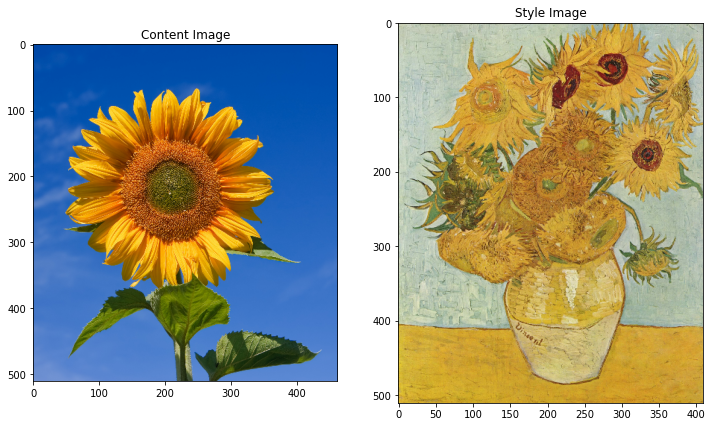

In [5]:
# Show the inputs

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

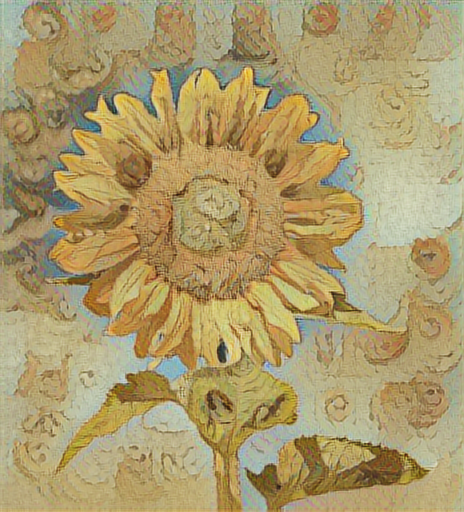

In [6]:
# Perform neural style transfer using image stylization module available on TensorFlow hub
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

**Well, the result is not quite van Goghish, but still very interesting. Can even pretend to be a piece of contemporary arts. The main problem are the spirals around the sunflower, a feature the network recognise to be highly important. Let's see whether we can get rid off these spirals when re-build a neural style network step by step following the tutorial and tweaking some parameters.**

In [0]:
# Content layer where we'll pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
# Load VGG19 model for image classificaiton to extract style features

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [0]:
# Define a model for the content and the style

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [0]:
# Define Gram matrix to determine the style of an image that can be described 
# by the means and correlations across the different feature maps

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [0]:
# Build a model that retuns the style and the content tensors

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
# Extract the features

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']


Define the loss and train the model

In [0]:
# Set your style and content target values

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
# Define a tf.Variable to contain the image to optimise.

image = tf.Variable(content_image)

In [0]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
# Define the optimiser

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
#opt = tf.optimizers.RMSprop(learning_rate=0.01)

In [0]:
# Use a weighted combination of the two losses to get the total loss:

style_weight = 1e-2
content_weight = 1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

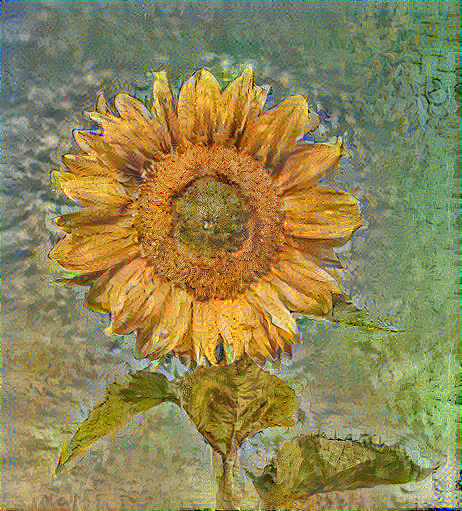

Train step: 1000
Total time: 48.0


In [107]:
# Train the model 

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

Use regularisation to remove high frequencies



In [0]:
total_variation_weight = 50

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
image = tf.Variable(content_image)

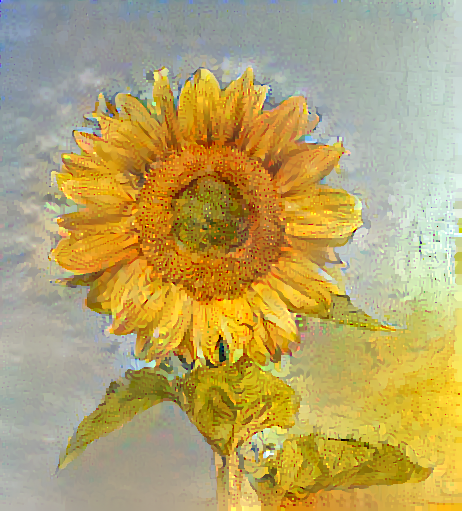

Train step: 20000
Total time: 961.5


In [113]:
import time
start = time.time()

epochs = 200
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


**We were able to get rid off the nasty spirals. However, the picture looks too photographic even after 200 epochs. It is missing the level of abstraction seen in van Gogh's pictures. Unfortunately, this level of abstraction is not possible to achieve (at least, not via changing the number of epochs, the optimiser, and the optimiser's learning rate). The problem is the limited number (5) of convolutional blocks in the model VGG19. Thus, it is worth trying to use a pre-trained model of a higher level of complexity (perhaps, Inception?).**